In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astropy import units as u
from astropy import constants as c
# from scipy.integrate import quad, dblquad
from scipy.interpolate import CubicSpline

In [2]:
P_std = 101325  # Pa
T_15C = 288.15  # K
e_charge = 1.602e-19  # C
mu_air = 1.00000037*c.mu0.value

In [3]:
PMT_min = 185e-9  # m
PMT_max = 650e-9  # m

blue_UV = 380e-9  # m
UVB_UVC = 280e-9  # m
UV_limit = 250e-9  # m

In [4]:
D = 12  # m

In [5]:
fixed_n = 1.0003
# atmos_height = 112.8e3  # m
atmos_height = 11e3  # m
veritas_alt = 1268  # m

In [6]:
muon_mass = (105.65837 * u.MeV/c.c**2).to(u.kg).value  # kg
muon_lifetime = 2.19698e-6  # s

In [7]:
constant_efficiency_factor = 0.88 * 0.97

In [8]:
measurements_dir = '../telescope_efficiency/'
qe_file = measurements_dir + 'quantum_efficiency.txt'
ref_T1_file = measurements_dir + 'reflectivity_T1.txt'
ref_T2_file = measurements_dir + 'reflectivity_T2.txt'
ref_T3_file = measurements_dir + 'reflectivity_T3.txt'
ref_T4_file = measurements_dir + 'reflectivity_T4.txt'

In [9]:
wvl_qe, qe = np.loadtxt(qe_file, skiprows=1, unpack=True)

In [10]:
wvl_ref_T1, ref_T1 = np.loadtxt(ref_T1_file, skiprows=1, unpack=True)
wvl_ref_T2, ref_T2 = np.loadtxt(ref_T2_file, skiprows=1, unpack=True)
wvl_ref_T3, ref_T3 = np.loadtxt(ref_T3_file, skiprows=1, unpack=True)
wvl_ref_T4, ref_T4 = np.loadtxt(ref_T4_file, skiprows=1, unpack=True)

In [11]:
qe_fct = CubicSpline(wvl_qe * 1e-9, qe)

ref_T1_fct = CubicSpline(wvl_ref_T1 * 1e-9, ref_T1)
ref_T2_fct = CubicSpline(wvl_ref_T2 * 1e-9, ref_T2)
ref_T3_fct = CubicSpline(wvl_ref_T3 * 1e-9, ref_T3)
ref_T4_fct = CubicSpline(wvl_ref_T4 * 1e-9, ref_T4)

ref_avg = np.mean((ref_T1, ref_T2, ref_T3, ref_T4), axis=0)
ref_fct = CubicSpline(wvl_ref_T1 * 1e-9, ref_avg)

In [12]:
wvl_range = np.linspace(UV_limit, PMT_max, 10000)

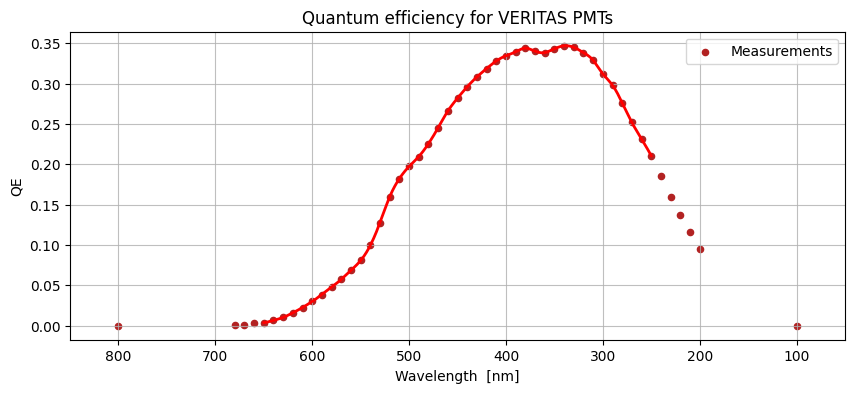

In [13]:
fig, ax = plt.subplots(figsize=(10, 4))

plt.plot(wvl_range, qe_fct(wvl_range), c='red', lw=2)
plt.scatter(wvl_qe * 1e-9, qe, color='firebrick', s=20, label='Measurements')

plt.grid(alpha=0.8)
plt.xlabel('Wavelength  [nm]')
plt.ylabel('QE')
plt.title('Quantum efficiency for VERITAS PMTs')

ticks = ax.xaxis.axes.get_xticks()
ticks_nm = [str(int(tick * 1e9)) for tick in ticks]
plt.xticks(ticks=ticks, labels=ticks_nm)

# plt.xlim(PMT_max, UV_limit)
plt.xlim(850e-9, 50e-9)

plt.legend()
plt.show()

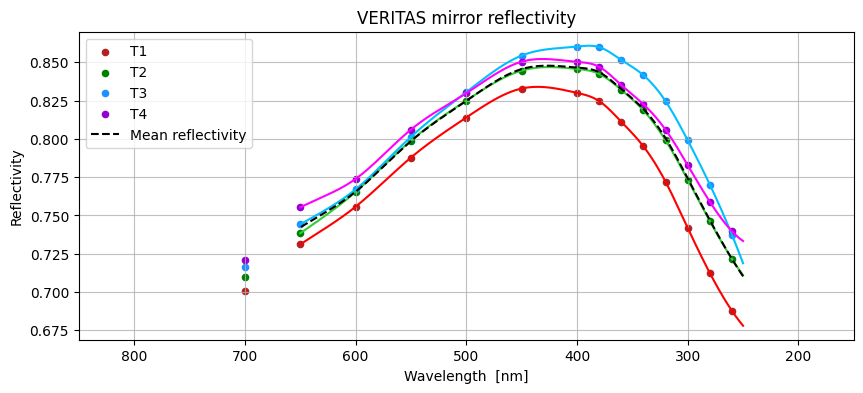

In [14]:
fig, ax = plt.subplots(figsize=(10, 4))

plt.plot(wvl_range, ref_T1_fct(wvl_range), c='red', lw=1.5)
plt.scatter(wvl_ref_T1 * 1e-9, ref_T1, color='firebrick', s=20, label='T1')

plt.plot(wvl_range, ref_T2_fct(wvl_range), c='limegreen', lw=1.5)
plt.scatter(wvl_ref_T2 * 1e-9, ref_T2, color='green', s=20, label='T2')

plt.plot(wvl_range, ref_T3_fct(wvl_range), c='deepskyblue', lw=1.5)
plt.scatter(wvl_ref_T3 * 1e-9, ref_T3, color='dodgerblue', s=20, label='T3')

plt.plot(wvl_range, ref_T4_fct(wvl_range), c='fuchsia', lw=1.5)
plt.scatter(wvl_ref_T4 * 1e-9, ref_T4, color='darkviolet', s=20, label='T4')

plt.plot(wvl_range, ref_fct(wvl_range), c='black', lw=1.5, ls='--', label='Mean reflectivity')

plt.grid(alpha=0.8)
plt.xlabel('Wavelength  [nm]')
plt.ylabel('Reflectivity')
plt.title('VERITAS mirror reflectivity')

ticks = ax.xaxis.axes.get_xticks()
ticks_nm = [str(int(tick * 1e9)) for tick in ticks]
plt.xticks(ticks=ticks, labels=ticks_nm)

# plt.xlim(PMT_max, UV_limit)
plt.xlim(850e-9, 150e-9)

plt.legend()
plt.show()

In [15]:
optimal_wvl_index = np.argmax(qe_fct(wvl_range) * ref_fct(wvl_range))
optimal_wvl = wvl_range[optimal_wvl_index]
print('Optimal detection wavelength: {} nm'.format(int(optimal_wvl * 1e9)))

Optimal detection wavelength: 380 nm


In [16]:
dry_adiab_lapse_rate = 9.76e-3  # K / m
molar_mass_dry_air = 0.02896968  # kg/mol

In [17]:
def get_pressure(alt):

    exponent = (c.g0.value * molar_mass_dry_air) / (c.R.value * dry_adiab_lapse_rate)
    base = 1 - (dry_adiab_lapse_rate * alt / T_15C)

    return P_std * base ** exponent

In [18]:
def get_temp(alt):
    return T_15C - (dry_adiab_lapse_rate * alt)

In [19]:
# This is to provide some weak dependence of n on lambda.
# This has a modest but appreciable impact in the Frank-Tamm equation due to the factor (1 - 1 / (beta * n))**2)
# Still regard lambda as being photon wavelength in vacuum; lambda = c / nu

def n_air(lam, P=P_std, T=T_15C):
    
    return 1 + 7.76e-7 * (1 + 7.52e-15 / lam**2) * P/T

In [20]:
def d2Ndxdlam(lam, alt, beta, q=e_charge, mu=mu_air):

    P = get_pressure(alt)
    T = get_temp(alt)

    return np.pi * q**2 * mu / c.h.value * (c.c.value / lam**2) * (1 - 1 / (beta * n_air(lam, P, T))**2)

In [21]:
# def dNdx(lam_low, lam_high, alt, beta, q=e_charge, mu=mu_air):

#     return quad(d2Ndxdlam, lam_low, lam_high, args=(alt, beta, q, mu))[0]

In [22]:
def detect_d2Ndxdlam(lam, alt, beta, q=e_charge, mu=mu_air):

    return constant_efficiency_factor * qe_fct(lam) * ref_fct(lam) * d2Ndxdlam(lam, alt, beta, q, mu)

In [23]:
# def detect_dNdx(lam_low, lam_high, alt, beta, q=e_charge, mu=mu_air):

#     return quad(detect_d2Ndxdlam, lam_low, lam_high, args=(alt, beta, q, mu))[0]

In [24]:
def get_beta(E, m=c.m_e.value):

    return np.sqrt(1 - m**2 * c.c.value**4 / E**2)

In [25]:
def get_gamma(E, m=c.m_e.value):

    return E / (m * c.c.value**2)

In [26]:
def decay_prob(t, lifetime):

    return 1 - np.exp(-t / lifetime)

In [27]:
def decay_prob_dens(t, lifetime):

    return np.exp(-t / lifetime) / lifetime

In [28]:
def get_cherenkov_angle(beta, n=fixed_n):

    return np.arccos(1 / (beta * n))

In [29]:
# def get_detection_length(lam, beta):
    
#     n = n_air(lam)
#     angle = get_cherenkov_angle(beta, n)
    
#     length = D/2 / np.tan(angle)
#     if length < atmos_height:
#         return length
#     else:
#         return atmos_height

In [30]:
# def get_detection_length(lam, beta):
    
#     for h in np.linspace(atmos_height, veritas_alt, 10000):
#         P = get_pressure(h)
#         T = get_temp(h)
#         n = n_air(lam, P, T)
#         angle = get_cherenkov_angle(beta, n)
#         dist = (h - veritas_alt) * np.tan(angle)

#         if dist <= D/2:
#             return h
    
#     return veritas_alt

In [31]:
# def detect_N(lam_low, lam_high, beta, q=e_charge, mu=mu_air):

#     return dblquad(lambda x, w: d2Ndxdlam(w, x, beta, q, mu), 
#                    lam_low, lam_high, 
#                    veritas_alt, lambda w: get_detection_length(w, beta))[0]

In [32]:
# Minimum muon energy (in GeV) to emit Cherenkov radiation in air

min_muon_gamma = (1 - fixed_n**-2) ** -0.5
min_muon_E = min_muon_gamma * muon_mass * c.c.value**2 * u.J.to(u.GeV)
min_muon_E

4.314455366018915

In [33]:
# Make arrays of muon energies

muon_E_span = np.logspace(np.log10(min_muon_E), np.log10(150e3), 10000)[1:]  # GeV
muon_energies = np.array([5, 10, 50, 100, 500, 1e3, 10e3, 100e3])  # GeV

In [34]:
# Time and distance arrays

times = np.linspace(0, 7e3 * muon_lifetime, 10000)
dists = np.linspace(0, atmos_height, 10000)

In [35]:
clrs = ['firebrick', 'darkorange', 'gold', 'lime', 'forestgreen', 'dodgerblue', 'blueviolet', 'fuchsia']

In [36]:
P_vts = get_pressure(veritas_alt)
T_vts = get_temp(veritas_alt)

In [37]:
# Calculate Cherenkov angles = muon ring radius (angular size)

betas = get_beta(E=muon_E_span * u.GeV.to(u.J), m=muon_mass)

angles = np.zeros_like(betas)
for i, beta in enumerate(betas):
    if beta > 1 / n_air(optimal_wvl, P_vts, T_vts):
        angles[i] = get_cherenkov_angle(beta, n=n_air(optimal_wvl, P_vts, T_vts))
    else:
        angles[i] = np.nan
        
angles_deg = angles / np.pi * 180

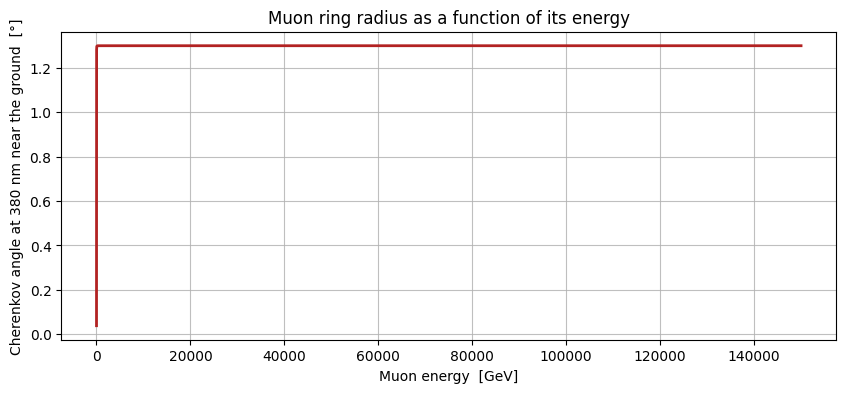

In [38]:
fig, ax = plt.subplots(figsize=(10, 4))

plt.plot(muon_E_span, angles_deg, c='firebrick', lw=2)

plt.grid(alpha=0.8)
plt.xlabel('Muon energy  [GeV]')
plt.ylabel('Cherenkov angle at {} nm near the ground  [°]'.format(int(optimal_wvl * 1e9)))
plt.title('Muon ring radius as a function of its energy')

plt.show()

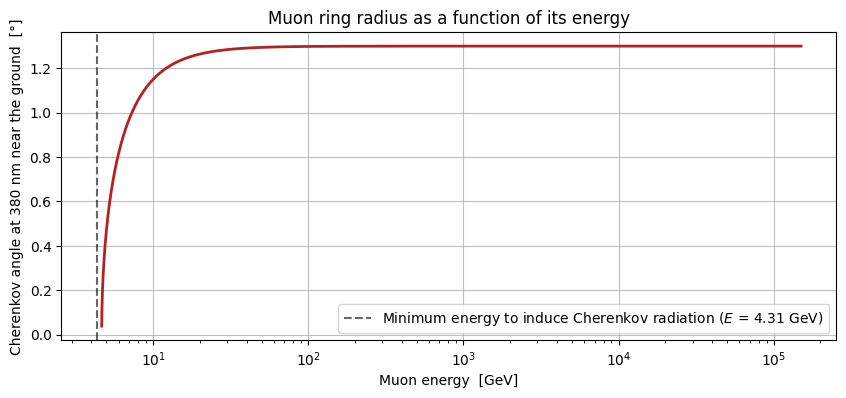

In [39]:
fig, ax = plt.subplots(figsize=(10, 4))

plt.plot(muon_E_span, angles_deg, c='firebrick', lw=2)
plt.axvline(x=min_muon_E, color='black', ls='--', lw=1.5, alpha=0.6,
            label=r'Minimum energy to induce Cherenkov radiation ($E$ = {} GeV)'.format(round(min_muon_E, 2)))

plt.grid(alpha=0.8)
plt.xlabel('Muon energy  [GeV]')
plt.ylabel('Cherenkov angle at {} nm near the ground  [°]'.format(int(optimal_wvl * 1e9)))
plt.title('Muon ring radius as a function of its energy')

plt.xscale('log')

plt.legend()
plt.show()

In [40]:
# Note that, where Cherenkov angle is rapidly changing (low energies),
# angle might be modestly increasing with Cherenkov photon wavelength
# due to the weak dependence of n on wavelength.

In [41]:
# Calculate Cherenkov angles for specific muon energies

some_betas = get_beta(E=muon_energies * u.GeV.to(u.J), m=muon_mass)
some_angles = get_cherenkov_angle(some_betas, n=n_air(optimal_wvl, P_vts, T_vts))
some_angles_deg = some_angles / np.pi * 180

In [42]:
print('Muon ring radii at {} nm near the ground:'.format(int(optimal_wvl * 1e9)))
for i, E in enumerate(muon_energies):
    if E < 1e3:
        text = str(int(E)) + '-GeV muon:'
    else:
        text = str(int(E/1e3)) + '-TeV muon:'
    print(text, str(round(some_angles_deg[i], 4)) + '°')

Muon ring radii at 380 nm near the ground:
5-GeV muon: 0.4713°
10-GeV muon: 1.1497°
50-GeV muon: 1.2937°
100-GeV muon: 1.2979°
500-GeV muon: 1.2993°
1-TeV muon: 1.2993°
10-TeV muon: 1.2993°
100-TeV muon: 1.2993°


In [44]:
# Double integration

true_ring_intensities = np.zeros_like(betas)
wavelengths = np.linspace(PMT_max, UV_limit, 10000)

dw = 1e-11 # m
dx = 1e-2  # m
heights = np.arange(veritas_alt, atmos_height, dx)

for i, beta in enumerate(betas):
    
    for height in heights:
       
        h = height + dx/2
        P = get_pressure(h)
        T = get_temp(h)
        
        okay = True
        j = 0
        max_wavelength = wavelengths[j]

        s = 0
    
        while okay and not beta > 1 / n_air(max_wavelength, P, T):
            j += 1
            try:
                max_wavelength = wavelengths[j]
            except:
                okay = False
            
        if okay:
            for wavelength in np.arange(UV_limit, max_wavelength, dw):
                
                w = wavelength + dw/2
                ss = 0
                
                n = n_air(w, P, T)
                angle = get_cherenkov_angle(beta, n)
                if (h - veritas_alt) * np.tan(angle) <= D/2:
                    ss += detect_d2Ndxdlam(lam=w, alt=h, beta=beta) * dw * dx
        else:
            ss = 0

        s += ss
        
    true_ring_intensities[i] = s

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))

plt.plot(muon_E_span, true_ring_intensities, c='firebrick', lw=2)
plt.axvline(x=min_muon_E, color='black', ls='--', lw=1.5, alpha=0.6,
            label=r'Minimum energy to induce Cherenkov radiation ($E$ = {} GeV)'.format(round(min_muon_E, 2)))

plt.grid(alpha=0.8)
plt.xlabel('Muon energy  [GeV]')
plt.ylabel(r'$N$')
plt.title('Photoelectrons collected from muon ring as a function of energy')

plt.xscale('log')

plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))

plt.plot(angles_deg, true_ring_intensities, c='firebrick', lw=2)

plt.grid(alpha=0.8)
plt.xlabel('Muon ring radius (Cherenkov angle at {} nm near the ground)  [°]'.format(int(optimal_wvl * 1e9)))
plt.ylabel(r'$N$')
plt.title('Photoelectrons collected from muon ring as a function of radius')

plt.xlim(xmin=0)

plt.show()